In [ ]:
#!pip install datasets

In [ ]:
#!pip install torchmetrics[visual]

In [ ]:
import pandas as pd
import re
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryCalibrationError

In [ ]:
df = pd.read_csv("/content/pacemaker50K.csv", dtype=str, low_memory=False)
df = df[df["FOI_TEXT"].notna()]
df = df[df["ADVERSE_EVENT_FLAG"].isin(['Y', 'N', 'True', 'False', True, False])]
df["ADVERSE_EVENT_FLAG"] = df["ADVERSE_EVENT_FLAG"].map({'Y': 1, 'N': 0, 'True': 1, 'False': 0, True: 1, False: 0})
df["FOI_TEXT"] = df["FOI_TEXT"].astype(str)
df = df[df["FOI_TEXT"].str.strip() != ""]

In [ ]:
train_df, test_df = train_test_split(
    df[["FOI_TEXT", "ADVERSE_EVENT_FLAG"]].rename(columns={"ADVERSE_EVENT_FLAG": "label"}),
    test_size=0.2,
    stratify=df["ADVERSE_EVENT_FLAG"],
    random_state=42
)

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# def tokenize(example):
#     return tokenizer(example["FOI_TEXT"], truncation=True)

# tokenized_train = train_dataset.map(tokenize, batched=True)
# tokenized_test = test_dataset.map(tokenize, batched=True)
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize(example):
    return tokenizer(example["FOI_TEXT"], padding=True, truncation=True, max_length=512) # add padding and max_length

tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # DataCollatorWithPadding will handle padding automatically

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=2)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# training arguments
training_args = TrainingArguments(
    output_dir="./biobert_results",
    # evaluation_strategy="epoch",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    remove_unused_columns=False
)

In [ ]:
# trainer and training BioBert
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train,
#     eval_dataset=tokenized_test,
#     tokenizer=tokenizer,
#     data_collator=data_collator
# )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,  # unused for calibration
    tokenizer=tokenizer,
    data_collator=data_collator,
    # remove_unused_columns=False  # keep "label" # Removed this unsupported argument
)

trainer.train() # Uncommented this line to start training

/tmp/ipython-input-41-1800850030.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.268300,0.310954
2,0.160300,0.320355
3,0.345300,0.329107


TrainOutput(global_step=15000, training_loss=0.26700241322120033, metrics={'train_runtime': 2850.3458, 'train_samples_per_second': 42.1, 'train_steps_per_second': 5.263, 'total_flos': 3.157315808768016e+16, 'train_loss': 0.26700241322120033, 'epoch': 3.0})


BioBERT Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      6531
           1       0.90      0.70      0.79      3469

    accuracy                           0.87     10000
   macro avg       0.88      0.83      0.85     10000
weighted avg       0.87      0.87      0.86     10000



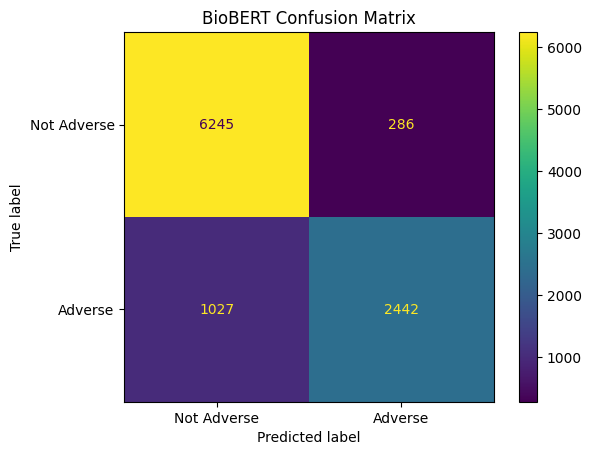

In [ ]:
preds_output = trainer.predict(tokenized_test)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

print("\nBioBERT Classification Report:")
print(classification_report(y_true, y_pred))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Not Adverse", "Adverse"])
plt.title("BioBERT Confusion Matrix")
plt.show()

In [ ]:
for col in ["FOI_TEXT", "some_other_unused_col"]:
    if col in tokenized_train.column_names:
        tokenized_train = tokenized_train.remove_columns([col])
    if col in tokenized_test.column_names:
        tokenized_test = tokenized_test.remove_columns([col])

In [ ]:
# 1. Clean the tokenized test set
usable = {"input_ids", "attention_mask", "token_type_ids", "label"}
tokenized_test_clean = tokenized_test.remove_columns(
    [c for c in tokenized_test.column_names if c not in usable]
)

# 2. Create validation loader
from torch.utils.data import DataLoader
val_loader = DataLoader(
    tokenized_test_clean,
    batch_size=16,
    collate_fn=data_collator
)


In [ ]:
print(tokenized_train.features)

{'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [ ]:
train_df["label"] = train_df["label"].astype(int)

In [ ]:
print(tokenized_test.column_names)

['label', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
import torch
from transformers import DataCollatorWithPadding

base_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def collate_with_label(features):
    # Pad sequences and get existing batch
    batch = base_collator(features)
    # Extract labels manually
    labels = torch.tensor([f["label"] for f in features], dtype=torch.long)
    batch["label"] = labels
    return batch

In [ ]:
from torch.utils.data import DataLoader

val_loader = DataLoader(
    tokenized_test,  # can use the original tokenized set
    batch_size=16,
    collate_fn=collate_with_label,
    shuffle=False
)

In [ ]:
batch = next(iter(val_loader))
print("Batch keys:", batch.keys())
print("Label batch shape:", batch["label"].shape)

Batch keys: KeysView({'input_ids': tensor([[  101,  1143, 12518,  ...,     0,     0,     0],
        [  101,  1142,   181,  ...,     0,     0,     0],
        [  101,  1122,  1108,  ...,     0,     0,     0],
        ...,
        [  101,  1191,  1869,  ...,     0,     0,     0],
        [  101,  1122,  1108,  ...,     0,     0,     0],
        [  101,  1103,  1730,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]), 'label': tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0

In [ ]:
# from torch.utils.data import DataLoader

# val_loader = DataLoader(
#     tokenized_test_clean,
#     batch_size=16,
#     collate_fn=data_collator  # ensures labels stay intact
# )

# from torch.utils.data import DataLoader

# # Clean & keep only necessary columns
# keep_cols = {"input_ids", "attention_mask", "token_type_ids", "label"}
# tokenized_val_clean = tokenized_test.remove_columns(
#     [c for c in tokenized_test.column_names if c not in keep_cols]
# )

# print("Validation columns:", tokenized_val_clean.column_names)
# # Expect: ['input_ids', 'attention_mask', 'token_type_ids', 'label']

# val_loader = DataLoader(
#     tokenized_val_clean,
#     batch_size=16,
#     collate_fn=data_collator,
#     shuffle=False
# )

In [ ]:
model.eval()
logits_list, labels_list = [], []

with torch.no_grad():
    for batch in val_loader:
        inputs = {k: v.to(model.device) for k, v in batch.items()
                  if k in ["input_ids", "attention_mask", "token_type_ids"]}
        outputs = model(**inputs)
        logits_list.append(outputs.logits.cpu())

        # Choose between 'label' and 'labels'
        if "label" in batch:
            label_batch = batch["label"]
        else:
            label_batch = batch["labels"]

        # Convert to tensor if needed
        if not torch.is_tensor(label_batch):
            label_batch = torch.tensor(label_batch)

        labels_list.append(label_batch.cpu())

logits = torch.cat(logits_list)
labels = torch.cat(labels_list)

print("✔️ Logits shape:", logits.shape)  # e.g., (N, 2)
print("✔️ Labels shape:", labels.shape)  # e.g., (N,)


✔️ Logits shape: torch.Size([10000, 2])
✔️ Labels shape: torch.Size([10000])


In [ ]:
import torch.nn as nn
import torch.optim as optim
# performing temperature scaling
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.tensor(1.0))

    def forward(self, logits):
        return logits / self.temperature

temp = TemperatureScaler().to(model.device)
optimizer = optim.LBFGS([temp.temperature], lr=0.01, max_iter=50)
nll = nn.CrossEntropyLoss()

def eval_fn():
    optimizer.zero_grad()
    loss = nll(temp(logits.to(model.device)), labels.to(model.device))
    loss.backward()
    return loss

optimizer.step(eval_fn)
print("🎯 Learned T:", temp.temperature.item())

🎯 Learned T: 1.1529285907745361


In [ ]:
# # move the logits to GPU before applying softmax and scaling
# import torch.nn.functional as F

# # Ensure logits are on the model's device
# logits = logits.to(model.device)

# # Apply temperature scaling followed by softmax (on the same device)
# scaled_logits = temp(logits)
# probs = F.softmax(scaled_logits, dim=1).cpu()  # move to CPU for further analysis or conversion

✅ ECE after scaling: 0.03440350294113159


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='BinaryCalibrationError'>)

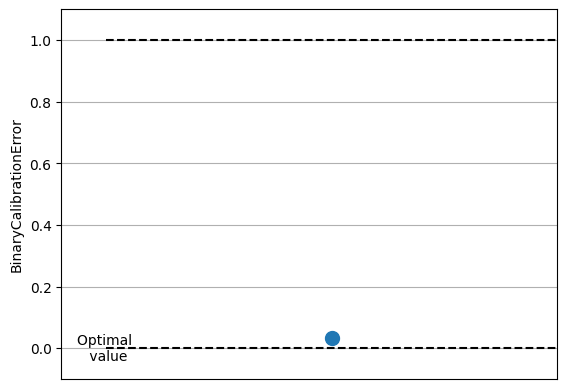

In [ ]:
import torch.nn.functional as F

# Step 1: Move temp and logits to CPU
temp_cpu = temp.to("cpu")
logits_cpu = logits.to("cpu")
labels_cpu = labels.to("cpu")

# Step 2: Run temperature scaling and softmax on CPU
scaled_logits_cpu = temp_cpu(logits_cpu)
probs_cpu = F.softmax(scaled_logits_cpu, dim=1)

# Step 3: Compute ECE
from torchmetrics.classification import BinaryCalibrationError

ece_metric = BinaryCalibrationError(n_bins=15, norm="l1")
ece = ece_metric(probs_cpu[:, 1], labels_cpu)
print("✅ ECE after scaling:", ece.item())
ece_metric.plot()


In [ ]:
# Make sure these are on CPU for portability
model.cpu()
temp_cpu = temp.to("cpu")

torch.save(model.state_dict(), "biobert_model.pth")
torch.save(temp_cpu.state_dict(), "temp_scaler.pth")
tokenizer.save_pretrained("./tokenizer")

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.txt',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

In [ ]:
# !zip -r biobert_model.zip biobert_finetuned_pacemaker

In [ ]:
# model.save_pretrained("biobert_finetuned_pacemaker", safe_serialization=False)
# tokenizer.save_pretrained("biobert_finetuned_pacemaker")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r biobert_finetuned_pacemaker /content/drive/MyDrive/

In [ ]:
!zip -r deployed_model.zip ./tokenizer config.json pytorch_model.bin temp_scaler.pth

	zip warning: name not matched: config.json
	zip warning: name not matched: pytorch_model.bin
  adding: tokenizer/ (stored 0%)
  adding: tokenizer/special_tokens_map.json (deflated 42%)
  adding: tokenizer/tokenizer.json (deflated 70%)
  adding: tokenizer/vocab.txt (deflated 49%)
  adding: tokenizer/tokenizer_config.json (deflated 74%)
  adding: temp_scaler.pth (deflated 58%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/pacemaker_deploy

In [ ]:
!cp -r tokenizer /content/drive/MyDrive/pacemaker_deploy/
!cp biobert_model.pth temp_scaler.pth /content/drive/MyDrive/pacemaker_deploy/

In [ ]:
!ls -R /content/drive/MyDrive/pacemaker_deploy/

/content/drive/MyDrive/pacemaker_deploy/:
biobert_model.pth  temp_scaler.pth  tokenizer

/content/drive/MyDrive/pacemaker_deploy/tokenizer:
special_tokens_map.json  tokenizer_config.json	tokenizer.json	vocab.txt
